In [52]:
# Import packages
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from matplotlib.pylab import rcParams
import itertools
import numpy as np
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook

# Preferred settings
warnings.simplefilter("ignore")


In [53]:
# Import saved data
df_TS = pd.read_csv('Data/df_TS_postCOV.csv')

# Set date column to datetime object
df_TS['Date'] = pd.to_datetime(df_TS['Date'])

# Set date column as index
df_TS.set_index('Date', inplace=True)

# Prepare Data

In [54]:
# Create df of only Brooklyn data, remove columns unhelpful to time series model 
df_bkln = df_TS.drop(columns = ['Injuries', 'Deaths','Accidents_Bx', 'Accidents_Man', 'Accidents_Qns', 'Accidents_SI',
                               'Accidents_Total'])

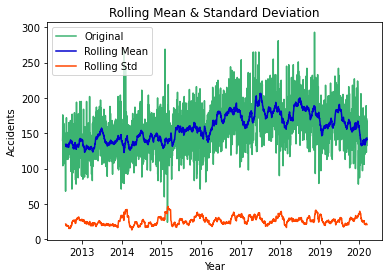

Test Statistic                   -3.239439
p-value                           0.017812
#Lags Used                       27.000000
Number of Observations Used    2783.000000
dtype: float64

In [55]:
# Visualize data, including 30-day rolling mean and standard deviation

roll_mean = df_bkln['Accidents_Bkln'].rolling(window=30, center=False).mean()
roll_std = df_bkln['Accidents_Bkln'].rolling(window=30, center=False).std()

plt.plot(df_bkln['Accidents_Bkln'],color='mediumseagreen', label='Original')
plt.plot(roll_mean, color='mediumblue', label='Rolling Mean')
plt.plot(roll_std, color='orangered', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Year')
plt.ylabel('Accidents')
plt.show(block=False)

# Dickey-Fuller test
test = adfuller(df_bkln['Accidents_Bkln'][1:-1])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput

Based on the above visualization and Dickey-Fuller p-value, we see that this data is stationary. We will therefore not perform differencing, a log transformation, or any other transformation on the data before fitting a model.

# Modeling

## Baseline Model: ARIMA with no Exogenous Variables

**ACF, PACF**

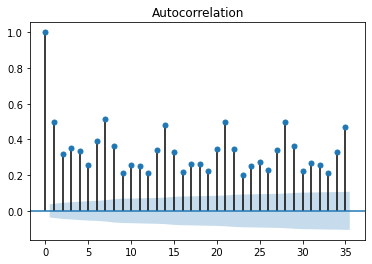

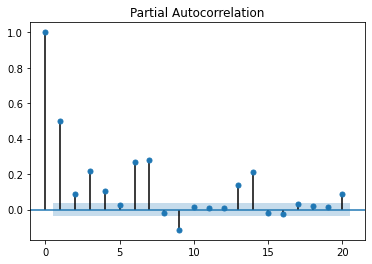

In [5]:
# ACF
plot_acf(df_bkln['Accidents_Bkln'], alpha=.05);

# PACF
plot_pacf(df_bkln['Accidents_Bkln'], alpha=.05, lags=20);

Based on the above ACF and PACF, when instantiating an ARIMA model, we would expect a relatively large number of MA terms due to the larger number of significant ACF points and a relatively small number of AR terms due to the small number of significant PACF points.

**Train-Test Split**

In [6]:
# Determine split point for 90%/10% train-test split
split_point = int(len(df_bkln) * 0.9)
df_bkln.iloc[split_point]

Accidents_Bkln         219
Season              Spring
Day of Week       Thursday
Weekend                  0
Holiday                  0
Name: 2019-06-06 00:00:00, dtype: object

In [7]:
# Train-test split
# Based on the above, 2019-06-06 will be the split point for our train and test sets

X = df_bkln.index
y = df_bkln['Accidents_Bkln']

train = df_bkln.loc[:'2019-06-06']
test = df_bkln.loc['2019-06-06':]

X_train, X_test = train.index , test.index
y_train, y_test = train['Accidents_Bkln'] , test['Accidents_Bkln']

**Grid Search**

In [8]:
# Determine best parameters for ARIMA model

# Define the p, d, and q parameters to take any value between 0 and 4
p = d = q = range(0,4)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# Run a grid with pdq parameters calculated to see corresponding AIC scores
ans_ARIMA = []
for comb in pdq:
    try:
        mod = ARIMA(y_train, order=comb)
        output = mod.fit()
        ans_ARIMA.append([comb, output.aic])
        print('ARIMA {} : AIC Calculated ={}'.format(comb,output.aic))
    except:
        continue

ARIMA (0, 0, 0) : AIC Calculated =24889.06534642138
ARIMA (0, 0, 1) : AIC Calculated =24313.43337649246
ARIMA (0, 0, 2) : AIC Calculated =24245.80487681006
ARIMA (0, 0, 3) : AIC Calculated =24168.121322036488
ARIMA (0, 1, 0) : AIC Calculated =24856.906666394152
ARIMA (0, 1, 1) : AIC Calculated =23913.105294904082
ARIMA (0, 1, 2) : AIC Calculated =23743.967737356656
ARIMA (0, 1, 3) : AIC Calculated =23744.614428449102
ARIMA (0, 2, 0) : AIC Calculated =27309.177569691765
ARIMA (0, 2, 1) : AIC Calculated =24857.92269379301
ARIMA (0, 2, 2) : AIC Calculated =23921.057204489774
ARIMA (0, 2, 3) : AIC Calculated =23752.78181420362
ARIMA (1, 0, 0) : AIC Calculated =24148.592032977664
ARIMA (1, 0, 1) : AIC Calculated =23917.30105980364
ARIMA (1, 0, 2) : AIC Calculated =23752.700662531846
ARIMA (1, 0, 3) : AIC Calculated =23753.155009517886
ARIMA (1, 1, 0) : AIC Calculated =24580.76677679175
ARIMA (1, 1, 1) : AIC Calculated =23765.310129583668
ARIMA (1, 1, 2) : AIC Calculated =23744.640689979653


In [9]:
# Find parameters with minimal AIC value
df_AIC = pd.DataFrame(ans_ARIMA, columns=['pdq', 'aic'])
df_AIC.sort_values(by='aic', ascending=True, inplace=True)
df_AIC[:10]

,pdq,aic
37,"(3, 1, 3)",23372.729778
28,"(2, 1, 3)",23723.364346
33,"(3, 0, 3)",23729.915847
35,"(3, 1, 1)",23741.361975
36,"(3, 1, 2)",23743.218368
6,"(0, 1, 2)",23743.967737
7,"(0, 1, 3)",23744.614428
18,"(1, 1, 2)",23744.640690
27,"(2, 1, 2)",23746.533535
19,"(1, 1, 3)",23746.610636


**Narrowing Down Parameters**

Observe lowest 10 AIC score parameter values to determine best model. Make sure p values are significant, and observe RMSEs to determind best overall model.

In [10]:
for pdq in df_AIC['pdq'][:10]:
    mod = ARIMA(y_train[:-1], order=pdq)
    mod_fit = mod.fit()
    print(mod_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:       D.Accidents_Bkln   No. Observations:                 2530
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -11673.216
Method:                       css-mle   S.D. of innovations             24.363
Date:                Fri, 12 Feb 2021   AIC                          23362.431
Time:                        00:08:42   BIC                          23409.119
Sample:                    07-02-2012   HQIC                         23379.371
                         - 06-05-2019                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0154      0.022      0.694      0.488      -0.028       0.059
ar.L1.D.Accidents_Bkln    -0.1267        nan        nan        nan         nan         nan
ar.L

                             ARIMA Model Results                              
Dep. Variable:       D.Accidents_Bkln   No. Observations:                 2530
Model:                 ARIMA(3, 1, 2)   Log Likelihood              -11859.606
Method:                       css-mle   S.D. of innovations             26.264
Date:                Fri, 12 Feb 2021   AIC                          23733.211
Time:                        00:08:46   BIC                          23774.063
Sample:                    07-02-2012   HQIC                         23748.033
                         - 06-05-2019                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0154      0.023      0.675      0.499      -0.029       0.060
ar.L1.D.Accidents_Bkln     0.2278      0.140      1.622      0.105      -0.047       0.503
ar.L

                             ARIMA Model Results                              
Dep. Variable:       D.Accidents_Bkln   No. Observations:                 2530
Model:                 ARIMA(1, 1, 3)   Log Likelihood              -11862.285
Method:                       css-mle   S.D. of innovations             26.292
Date:                Fri, 12 Feb 2021   AIC                          23736.570
Time:                        00:08:50   BIC                          23771.586
Sample:                    07-02-2012   HQIC                         23749.275
                         - 06-05-2019                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0156      0.024      0.637      0.524      -0.032       0.064
ar.L1.D.Accidents_Bkln    -0.0225      0.332     -0.068      0.946      -0.674       0.629
ma.L

From the above, we see that none of these parameters have significant p-values. We will now look at the next 10 lowest AIC scores in search of our best ARIMA model.

In [11]:
for pdq in df_AIC['pdq'][10:20]:
    mod = ARIMA(y_train[:-1], order=pdq)
    mod_fit = mod.fit()
    print(mod_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:      D2.Accidents_Bkln   No. Observations:                 2529
Model:                 ARIMA(3, 2, 2)   Log Likelihood              -11862.892
Method:                       css-mle   S.D. of innovations             26.277
Date:                Fri, 12 Feb 2021   AIC                          23739.784
Time:                        00:08:53   BIC                          23780.633
Sample:                    07-03-2012   HQIC                         23754.606
                         - 06-05-2019                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -4.673e-06   3.77e-05     -0.124      0.901   -7.86e-05    6.93e-05
ar.L1.D2.Accidents_Bkln     0.2724      0.020     13.702      0.000       0.233       0.311


                              ARMA Model Results                              
Dep. Variable:         Accidents_Bkln   No. Observations:                 2531
Model:                     ARMA(1, 3)   Log Likelihood              -11865.520
Method:                       css-mle   S.D. of innovations             26.280
Date:                Fri, 12 Feb 2021   AIC                          23743.039
Time:                        00:08:58   BIC                          23778.057
Sample:                    07-01-2012   HQIC                         23755.744
                         - 06-05-2019                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  157.3786      9.793     16.070      0.000     138.184     176.573
ar.L1.Accidents_Bkln     0.9977      0.001    670.678      0.000       0.995       1.001
ma.L1.Accide

                              ARMA Model Results                              
Dep. Variable:         Accidents_Bkln   No. Observations:                 2531
Model:                     ARMA(3, 1)   Log Likelihood              -11868.321
Method:                       css-mle   S.D. of innovations             26.309
Date:                Fri, 12 Feb 2021   AIC                          23748.642
Time:                        00:09:03   BIC                          23783.660
Sample:                    07-01-2012   HQIC                         23761.347
                         - 06-05-2019                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  157.4373      9.601     16.398      0.000     138.620     176.254
ar.L1.Accidents_Bkln     1.2633      0.021     59.719      0.000       1.222       1.305
ar.L2.Accide

From the above, we see that parameters (1,0,2) and (3,0,1) and significant p-values. We will look at the next 5 lowest AIC values to see if any others are significant so we can compare their RMSEs.

In [12]:
for pdq in df_AIC['pdq'][20:25]:
    mod = ARIMA(y_train[:-1], order=pdq)
    mod_fit = mod.fit()
    print(mod_fit.summary())

                              ARMA Model Results                              
Dep. Variable:         Accidents_Bkln   No. Observations:                 2531
Model:                     ARMA(2, 1)   Log Likelihood              -11876.995
Method:                       css-mle   S.D. of innovations             26.399
Date:                Fri, 12 Feb 2021   AIC                          23763.990
Time:                        00:09:04   BIC                          23793.171
Sample:                    07-01-2012   HQIC                         23774.577
                         - 06-05-2019                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  157.0711     10.395     15.110      0.000     136.697     177.445
ar.L1.Accidents_Bkln     1.2521      0.021     60.606      0.000       1.212       1.293
ar.L2.Accide

From the above, we see that parameters (2,0,1) and (1,0,1) are also significant. We will compare RMSE values for these parameters as well as (1,0,2) and (3,0,1).

**Determine Best ARIMA Model**

In [13]:
# Create RMSE function
def RMSE(pred):
    return np.sqrt(((pred-y_test)**2).mean())

# For loop to apply RMSE function to significant parameters
for pdq in [(2,0,1),(1,0,1),(1,0,2),(3,0,1)]:
    mod = ARIMA(y_train[:-1], order=pdq)
    mod_fit = mod.fit()
    mod_pred = mod_fit.predict(start='2019-06-06', end='2020-03-13', dynamic=False)
    print(pdq,': RMSE: ', RMSE(mod_pred), 'AIC: ', mod_fit.aic)

(2, 0, 1) : RMSE:  31.165035939197868 AIC:  23763.989544537177
(1, 0, 1) : RMSE:  29.358338851353853 AIC:  23906.471395129975
(1, 0, 2) : RMSE:  31.157632568828284 AIC:  23742.567169125687
(3, 0, 1) : RMSE:  31.09696604367429 AIC:  23748.641717972656


Through a combination of RMSE and AIC, an ARIMA model with parameters (1,0,1) is our best baseline model. We will now compare this baseline model to other types of time series models.

In [14]:
# Define baseline model for future comparison
base = ARIMA(y_train[:-1], order=(1,0,1))
base_fit = base.fit()
base_pred = base_fit.predict(start='2019-06-06', end='2020-03-13', dynamic=False)
base_RMSE = RMSE(base_pred)
base_AIC = base_fit.aic

print('Baseline model RMSE: ', base_RMSE)
print('Baseline model RMSE adj for range: ',
      base_RMSE/(df_bkln['Accidents_Bkln'].max()-df_bkln['Accidents_Bkln'].min()))
print('Baseline model AIC: ', base_AIC)




Baseline model RMSE:  29.358338851353853
Baseline model RMSE adj for range:  0.10913880613886191
Baseline model AIC:  23906.471395129975


## Model #2: Introducing Exogenous Variables: ARIMAX Model

Now that we have our baseline ARIMA model, we will try incorporating exogenous variables with an ARIMAX model.

**Clean Data for ARIMAX Model**

In [15]:
# Turn exogenous variables into integers so they work in the model
# Season
df_bkln['Season'] = np.where(df_bkln['Season']=='Fall', 1, df_bkln['Season'])
df_bkln['Season'] = np.where(df_bkln['Season']=='Winter', 2, df_bkln['Season'])
df_bkln['Season'] = np.where(df_bkln['Season']=='Spring', 3, df_bkln['Season'])
df_bkln['Season'] = np.where(df_bkln['Season']=='Summer', 4, df_bkln['Season'])

# Day of Week
df_bkln['Day of Week'] = np.where(df_bkln['Day of Week']=='Sunday', 1, df_bkln['Day of Week'])
df_bkln['Day of Week'] = np.where(df_bkln['Day of Week']=='Monday', 2, df_bkln['Day of Week'])
df_bkln['Day of Week'] = np.where(df_bkln['Day of Week']=='Tuesday', 3, df_bkln['Day of Week'])
df_bkln['Day of Week'] = np.where(df_bkln['Day of Week']=='Wednesday', 4, df_bkln['Day of Week'])
df_bkln['Day of Week'] = np.where(df_bkln['Day of Week']=='Thursday', 5, df_bkln['Day of Week'])
df_bkln['Day of Week'] = np.where(df_bkln['Day of Week']=='Friday', 6, df_bkln['Day of Week'])
df_bkln['Day of Week'] = np.where(df_bkln['Day of Week']=='Saturday', 7, df_bkln['Day of Week'])

# Weekend (these turned into strings when the data was imported from the csv)
df_bkln['Weekend'] = np.where(df_bkln['Weekend']=='0', 0, df_bkln['Weekend'])
df_bkln['Weekend'] = np.where(df_bkln['Weekend']=='1', 1, df_bkln['Weekend'])

# Holiday (these turned into strings when the data was imported from the csv)
df_bkln['Holiday'] = np.where(df_bkln['Holiday']=='0', 0, df_bkln['Holiday'])
df_bkln['Holiday'] = np.where(df_bkln['Holiday']=='1', 1, df_bkln['Holiday'])



**Redefine Train-Test Split with Cleaned Data**

In [16]:
# Train-test split
# Based on the above, 2019-06-06 will be the split point for our train and test sets

X = df_bkln.index
y = df_bkln['Accidents_Bkln']

train = df_bkln.loc[:'2019-06-06']
test = df_bkln.loc['2019-06-06':]

X_train, X_test = train.index , test.index
y_train, y_test = train['Accidents_Bkln'] , test['Accidents_Bkln']

In [17]:
# Make list of lists of exogenous data to be used in the model
list_of_lists = []
for column in list(train.iloc[:,1:].columns):
    list_of_lists.append(list(train[column]))
    
exog=np.column_stack(list_of_lists)


**Grid Search**

In [23]:
# Determine best parameters for ARIMAX model

# Define the p, d, and q parameters to take any value between 0 and 4
p = d = q = range(0,4)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# Run a grid with pdq parameters calculated to see corresponding AIC scores
ans_ARIMAX2 = []
for comb in pdq:
    try:
        mod = sm.tsa.ARIMA(endog=y_train,
                           exog=exog,
                           order=comb)
        output = mod.fit()
        ans_ARIMAX2.append([comb, output.aic])
        print('ARIMAX {} : AIC Calculated ={}'.format(comb,output.aic))
    except:
        continue

ARIMAX (0, 0, 0) : AIC Calculated =24284.295476847838
ARIMAX (0, 0, 1) : AIC Calculated =23656.83093237327
ARIMAX (0, 0, 2) : AIC Calculated =23460.369628830285
ARIMAX (0, 0, 3) : AIC Calculated =23323.318825663246
ARIMAX (0, 1, 0) : AIC Calculated =24198.432314392216
ARIMAX (0, 1, 1) : AIC Calculated =23200.42256186771
ARIMAX (0, 1, 2) : AIC Calculated =23128.54225647226
ARIMAX (0, 1, 3) : AIC Calculated =23124.615266430425
ARIMAX (0, 2, 0) : AIC Calculated =27065.75220863091
ARIMAX (0, 2, 1) : AIC Calculated =nan
ARIMAX (0, 2, 2) : AIC Calculated =23547.440918788965
ARIMAX (0, 2, 3) : AIC Calculated =23471.52149176063
ARIMAX (1, 0, 0) : AIC Calculated =23273.603852450295
ARIMAX (1, 0, 1) : AIC Calculated =22871.882718411696
ARIMAX (1, 0, 2) : AIC Calculated =22812.571302861732
ARIMAX (1, 0, 3) : AIC Calculated =22805.364464939084
ARIMAX (1, 1, 0) : AIC Calculated =23758.899111400297
ARIMAX (1, 1, 1) : AIC Calculated =23117.89602220333
ARIMAX (1, 1, 2) : AIC Calculated =23099.84831714

In [24]:
# Find parameters with minimal AIC value
df_AIC = pd.DataFrame(ans_ARIMAX2, columns=['pdq', 'aic'])
df_AIC.sort_values(by='aic', ascending=True, inplace=True)
df_AIC[:10]

,pdq,aic
25,"(2, 0, 2)",22785.338906
38,"(3, 0, 3)",22789.316442
36,"(3, 0, 1)",22794.870570
24,"(2, 0, 1)",22799.923779
37,"(3, 0, 2)",22800.728629
15,"(1, 0, 3)",22805.364465
26,"(2, 0, 3)",22810.786430
14,"(1, 0, 2)",22812.571303
13,"(1, 0, 1)",22871.882718
42,"(3, 1, 3)",22958.966950


**Determining Best Parameters**

Observe lowest 10 AIC score parameter values to determine best model. Make sure p values are significant, and observe RMSEs to determind best overall model.

In [25]:
for pdq in df_AIC['pdq'][:10]:
    mod = sm.tsa.ARIMA(endog=y_train,
                       exog=exog,
                       order=pdq)
    mod_fit = mod.fit()
    print(mod_fit.summary())
    

                              ARMA Model Results                              
Dep. Variable:         Accidents_Bkln   No. Observations:                 2532
Model:                     ARMA(2, 2)   Log Likelihood              -11382.669
Method:                       css-mle   S.D. of innovations             21.677
Date:                Fri, 12 Feb 2021   AIC                          22785.339
Time:                        00:11:16   BIC                          22843.707
Sample:                    07-01-2012   HQIC                         22806.515
                         - 06-06-2019                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  164.0008     10.746     15.262      0.000     142.940     185.062
x1                      -0.7930      0.993     -0.799      0.424      -2.739       1.153
x2          

                              ARMA Model Results                              
Dep. Variable:         Accidents_Bkln   No. Observations:                 2532
Model:                     ARMA(3, 2)   Log Likelihood              -11389.364
Method:                       css-mle   S.D. of innovations             21.734
Date:                Fri, 12 Feb 2021   AIC                          22800.729
Time:                        00:11:31   BIC                          22864.933
Sample:                    07-01-2012   HQIC                         22824.023
                         - 06-06-2019                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  165.5487      9.248     17.900      0.000     147.422     183.675
x1                      -1.1158      1.004     -1.111      0.267      -3.084       0.852
x2          

                              ARMA Model Results                              
Dep. Variable:         Accidents_Bkln   No. Observations:                 2532
Model:                     ARMA(1, 1)   Log Likelihood              -11427.941
Method:                       css-mle   S.D. of innovations             22.071
Date:                Fri, 12 Feb 2021   AIC                          22871.883
Time:                        00:11:43   BIC                          22918.577
Sample:                    07-01-2012   HQIC                         22888.824
                         - 06-06-2019                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  163.8299      5.218     31.397      0.000     153.603     174.057
x1                      -0.5257      1.415     -0.371      0.710      -3.300       2.249
x2          

We don't see any significant p values above, so will look at the next 10 lowest AIC scores.

In [26]:
for pdq in df_AIC['pdq'][10:20]:
    mod = sm.tsa.ARIMA(endog=y_train,
                       exog=exog,
                       order=pdq)
    mod_fit = mod.fit()
    print(mod_fit.summary())
    

                              ARMA Model Results                              
Dep. Variable:         Accidents_Bkln   No. Observations:                 2532
Model:                     ARMA(3, 0)   Log Likelihood              -11488.578
Method:                       css-mle   S.D. of innovations             22.607
Date:                Fri, 12 Feb 2021   AIC                          22995.156
Time:                        00:11:58   BIC                          23047.686
Sample:                    07-01-2012   HQIC                         23014.214
                         - 06-06-2019                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  161.0639      3.867     41.651      0.000     153.485     168.643
x1                       0.4672      1.328      0.352      0.725      -2.135       3.070
x2          

                             ARIMA Model Results                              
Dep. Variable:       D.Accidents_Bkln   No. Observations:                 2531
Model:                 ARIMA(1, 1, 3)   Log Likelihood              -11537.632
Method:                       css-mle   S.D. of innovations             23.084
Date:                Fri, 12 Feb 2021   AIC                          23095.263
Time:                        00:12:16   BIC                          23153.627
Sample:                    07-02-2012   HQIC                         23116.439
                         - 06-06-2019                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     23.4630      0.983     23.879      0.000      21.537      25.389
x1                        -0.0947      0.029     -3.321      0.001      -0.151      -0.039
x2  

                             ARIMA Model Results                              
Dep. Variable:       D.Accidents_Bkln   No. Observations:                 2531
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11550.948
Method:                       css-mle   S.D. of innovations             23.206
Date:                Fri, 12 Feb 2021   AIC                          23117.896
Time:                        00:12:24   BIC                          23164.587
Sample:                    07-02-2012   HQIC                         23134.836
                         - 06-06-2019                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     23.6110      1.055     22.389      0.000      21.544      25.678
x1                        -0.0785      0.028     -2.776      0.005      -0.134      -0.023
x2  

From the above, we see that the following parameters have significant p values:

(1,1,3)

(1,1,2)

(2,1,1)

(1,1,1)

We will observe RMSE and AIC values for these to determine our best working model.

In [27]:
# For loop to apply RMSE function to significant parameters
for (pdq) in [(1,1,3),(1,1,2),(2,1,1),(1,1,1)]:
    mod = sm.tsa.ARIMA(endog=y_train,
                           exog=exog,
                           order=pdq)
    mod_fit = mod.fit()
    mod_pred = mod_fit.predict(start='2019-06-06', end='2020-03-13', exog = test.iloc[:,1:], dynamic=False)
    mod_RMSE = RMSE(mod_pred)
    mod_AIC = mod_fit.aic
    print(pdq,' RMSE: ', mod_RMSE)
    print(pdq,' AIC: ', mod_AIC)  
    

(1, 1, 3)  RMSE:  160.895045060752
(1, 1, 3)  AIC:  23095.263272277058
(1, 1, 2)  RMSE:  160.89782129573413
(1, 1, 2)  AIC:  23099.84831714987
(2, 1, 1)  RMSE:  160.89269565447358
(2, 1, 1)  AIC:  23114.695316309477
(1, 1, 1)  RMSE:  160.88348277946082
(1, 1, 1)  AIC:  23117.89602220333


All of the above models have very similar RMSEs. We will therefore choose our best model based on AIC, which puts parameters (1,1,3) slightly ahead of the others. We will define this as our ARIMAX model and compare it to our baseline ARIMA model.

In [28]:
# Define ARIMAX model
ARIMAX = sm.tsa.ARIMA(endog=y_train, exog=exog, order=(1,1,3))
ARIMAX_fit = ARIMAX.fit()
ARIMAX_pred = ARIMAX_fit.predict(start='2019-06-06', end='2020-03-13', exog = test.iloc[:,1:], dynamic=False)
ARIMAX_RMSE = RMSE(ARIMAX_pred)
ARIMAX_AIC = ARIMAX_fit.aic

# Compare ARIMA and ARIMAX model RMSEs and AICs

print('ARIMA model RMSE: ', base_RMSE)
print('ARIMA model AIC: ', base_AIC)

print('ARIMAX model RMSE: ', ARIMAX_RMSE)
print('ARIMAX model AIC: ', ARIMAX_AIC)



ARIMA model RMSE:  29.358338851353853
ARIMA model AIC:  23906.471395129975
ARIMAX model RMSE:  160.895045060752
ARIMAX model AIC:  23095.263272277058


We see from the above that though our baseline model has a worse AIC score, it performs significantly better with RMSE. Since RMSE is what tells us more clearly how far off our predictions are, we will consider this the better model.

## Model #3: Introducing Seasonality: SARIMA Model

Or data is seasonal, so we would expect a SARIMA model to produce better results than our baseline ARIMA one.

**Resample Weekly Data**

Since data is seasonal by year, our period value would ordinarily be 365 observations. This is too large for a SARIMA model, so will create a df with weekly data and instead use a period value of 52.

In [29]:
# Create df of weekly data
df_bkln_wk = df_bkln.resample('W')
df_bkln_wk_mean = df_bkln_wk.mean()


In [30]:
# When we introduce exogenous data, the weekend column won't be valuable--remove it
df_bkln_wk_mean.drop(columns=['Weekend'], inplace=True)

# Change holiday column to be a 1 if there is any holiday that week,
# ie if the value is greater than 0
df_bkln_wk_mean['Holiday'] = np.where(df_bkln_wk_mean['Holiday']>0, 1, 0)

# Add in Season
df_bkln_wk_mean['Season'] = 0

def season(month,season):
    df_bkln_wk_mean['Season'] = np.where((df_bkln_wk_mean.index.month==month),
                                         season,df_bkln_wk_mean['Season'])

for month in range (1,4):
    season(month,2)
    
for month in range (4,7):
    season(month,3)
    
for month in range (7,10):
    season(month,4)

for month in range (10,13):
    season(month,1)

# Holiday
df_bkln_wk_mean['Holiday'] = np.where(df_bkln_wk_mean['Holiday']=='0',
                                      0, df_bkln_wk_mean['Holiday'])
df_bkln_wk_mean['Holiday'] = np.where(df_bkln_wk_mean['Holiday']=='1',
                                      1, df_bkln_wk_mean['Holiday'])

# Observe new df head
df_bkln_wk_mean.head()

,Accidents_Bkln,Holiday,Season
Date,,,
2012-07-01,140.000000,0,4
2012-07-08,138.571429,1,4
2012-07-15,140.428571,0,4
2012-07-22,130.285714,0,4
2012-07-29,125.571429,0,4


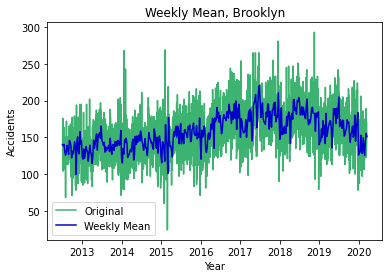

Test Statistic                  -2.180011
p-value                          0.213580
#Lags Used                       6.000000
Number of Observations Used    395.000000
dtype: float64

In [31]:
# Plot weekly data compared to daily
plt.plot(df_bkln['Accidents_Bkln'],color='mediumseagreen', label='Original')
plt.plot(df_bkln_wk_mean['Accidents_Bkln'], color='mediumblue', label='Weekly Mean')
plt.legend(loc='best')
plt.title('Weekly Mean, Brooklyn')
plt.xlabel('Year')
plt.ylabel('Accidents')
plt.show(block=False)

# Dickey-Fuller test
test = adfuller(df_bkln_wk_mean['Accidents_Bkln'][:-1])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput

Based on the above Dickey-Fuller p-value, this data is not stationary. We will difference this data to attempt stationarity.

**Differencing**

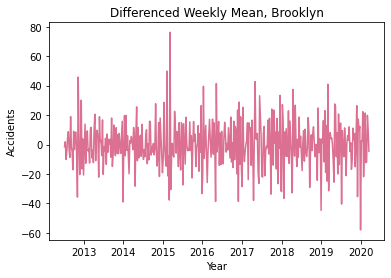

Test Statistic                -1.337120e+01
p-value                        5.193698e-25
#Lags Used                     5.000000e+00
Number of Observations Used    3.950000e+02
dtype: float64

In [32]:
# Difference data
diff = df_bkln_wk_mean['Accidents_Bkln'].diff()

# Plot differenced data
plt.plot(diff, color='palevioletred', label='Differenced Rolling Weekly Mean')
plt.title('Differenced Weekly Mean, Brooklyn')
plt.xlabel('Year')
plt.ylabel('Accidents')
plt.show(block=False)

# Dickey-Fuller test
test = adfuller(diff[1:-1])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput

Differencing once achieved stationarity, so we would expect our SARIMA model to have a d value of at least 1.

**ACF, PACF for Weekly Data**

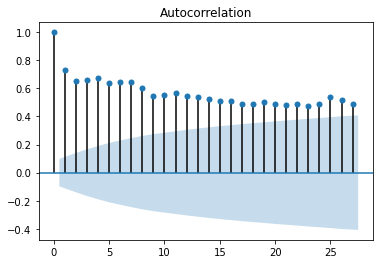

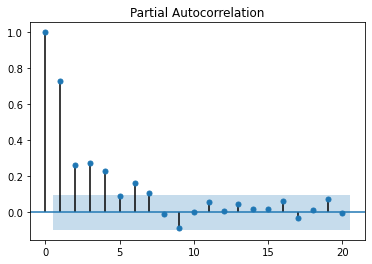

In [33]:
# ACF for weekly data
plot_acf(df_bkln_wk_mean['Accidents_Bkln'], alpha=.05);

# PACF for weekly data
plot_pacf(df_bkln_wk_mean['Accidents_Bkln'], alpha=.05, lags=20);

**Redo Train-Test Split for Weekly Data**

In [34]:
# Determine split point for 90%/10% train-test split
split_point = int(len(df_bkln_wk_mean) * 0.9)
df_bkln_wk_mean.iloc[split_point]

Accidents_Bkln    189.571429
Holiday             0.000000
Season              3.000000
Name: 2019-06-09 00:00:00, dtype: float64

In [35]:
# Train-test split
# Based on the above, 2019-06-06 will be the split point for our train and test sets

X = df_bkln_wk_mean.index
y = df_bkln_wk_mean['Accidents_Bkln']

train = df_bkln_wk_mean.loc[:'2019-06-06']
test = df_bkln_wk_mean.loc['2019-06-06':]

X_train, X_test = train.index , test.index
y_train, y_test = train['Accidents_Bkln'] , test['Accidents_Bkln']

**Grid Search for SARIMA Model**

In [36]:
# Determine best parameters for SARIMA model

# Define the p, d, and q parameters to take any value between 0 and 2
# Using smaller range due to many combinations
p = d = q = range(0,2)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, d, q triplets
# Choose s value of 52 because data is now weekly and a cycle is one year

pdqs = [(x[0],x[1],x[2], 52) for x in pdq]

# Run a grid search with pdq parameters calculated to see corresponding AIC scores
ans_SARIMA = []
for comb in pdq:
    for combs in tqdm_notebook(pdqs):
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans_SARIMA.append([comb, combs, output.aic])
            print('ARIMA {} x {}52 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 52)52 : AIC Calculated =4688.513155251688
ARIMA (0, 0, 0) x (0, 0, 1, 52)52 : AIC Calculated =3744.197402891099
ARIMA (0, 0, 0) x (0, 1, 0, 52)52 : AIC Calculated =2672.04491297869
ARIMA (0, 0, 0) x (0, 1, 1, 52)52 : AIC Calculated =2253.2249842558335
ARIMA (0, 0, 0) x (1, 0, 0, 52)52 : AIC Calculated =2653.471562077059
ARIMA (0, 0, 0) x (1, 0, 1, 52)52 : AIC Calculated =2589.583779084295
ARIMA (0, 0, 0) x (1, 1, 0, 52)52 : AIC Calculated =2261.216002605046
ARIMA (0, 0, 0) x (1, 1, 1, 52)52 : AIC Calculated =2254.854606033019



ARIMA (0, 0, 1) x (0, 0, 0, 52)52 : AIC Calculated =4243.944139724098
ARIMA (0, 0, 1) x (0, 0, 1, 52)52 : AIC Calculated =3413.4114807047663
ARIMA (0, 0, 1) x (0, 1, 0, 52)52 : AIC Calculated =2620.0997501546453
ARIMA (0, 0, 1) x (0, 1, 1, 52)52 : AIC Calculated =2193.05395384255
ARIMA (0, 0, 1) x (1, 0, 0, 52)52 : AIC Calculated =2623.2810421863305
ARIMA (0, 0, 1) x (1, 0, 1, 52)52 : AIC Calculated =2618.2775024390767
ARIMA (0, 0, 1) x (1, 1, 0, 52)52 : AIC Calculated =2208.97442187371
ARIMA (0, 0, 1) x (1, 1, 1, 52)52 : AIC Calculated =2194.9985994321733



ARIMA (0, 1, 0) x (0, 0, 0, 52)52 : AIC Calculated =3030.3573761646394
ARIMA (0, 1, 0) x (0, 0, 1, 52)52 : AIC Calculated =2593.433247610308
ARIMA (0, 1, 0) x (0, 1, 0, 52)52 : AIC Calculated =2719.496883252071
ARIMA (0, 1, 0) x (0, 1, 1, 52)52 : AIC Calculated =2176.0987479855994
ARIMA (0, 1, 0) x (1, 0, 0, 52)52 : AIC Calculated =2592.9887425744073
ARIMA (0, 1, 0) x (1, 0, 1, 52)52 : AIC Calculated =2585.817117165897
ARIMA (0, 1, 0) x (1, 1, 0, 52)52 : AIC Calculated =2223.072112687211
ARIMA (0, 1, 0) x (1, 1, 1, 52)52 : AIC Calculated =2172.421355994424



ARIMA (0, 1, 1) x (0, 0, 0, 52)52 : AIC Calculated =2896.134333582977
ARIMA (0, 1, 1) x (0, 0, 1, 52)52 : AIC Calculated =2468.6453335271653
ARIMA (0, 1, 1) x (0, 1, 0, 52)52 : AIC Calculated =2550.550304031077
ARIMA (0, 1, 1) x (0, 1, 1, 52)52 : AIC Calculated =2046.3881165089497
ARIMA (0, 1, 1) x (1, 0, 0, 52)52 : AIC Calculated =2466.9011111619466
ARIMA (0, 1, 1) x (1, 0, 1, 52)52 : AIC Calculated =2445.593345158103
ARIMA (0, 1, 1) x (1, 1, 0, 52)52 : AIC Calculated =2099.4064054918053
ARIMA (0, 1, 1) x (1, 1, 1, 52)52 : AIC Calculated =2047.0345408073285



ARIMA (1, 0, 0) x (0, 0, 0, 52)52 : AIC Calculated =3039.0089265262577
ARIMA (1, 0, 0) x (0, 0, 1, 52)52 : AIC Calculated =2601.9625977642827
ARIMA (1, 0, 0) x (0, 1, 0, 52)52 : AIC Calculated =2619.6745169885703
ARIMA (1, 0, 0) x (0, 1, 1, 52)52 : AIC Calculated =2153.824570785531
ARIMA (1, 0, 0) x (1, 0, 0, 52)52 : AIC Calculated =2593.7389250133115
ARIMA (1, 0, 0) x (1, 0, 1, 52)52 : AIC Calculated =2532.9030851356138
ARIMA (1, 0, 0) x (1, 1, 0, 52)52 : AIC Calculated =2169.6315806513717
ARIMA (1, 0, 0) x (1, 1, 1, 52)52 : AIC Calculated =2156.626160446799



ARIMA (1, 0, 1) x (0, 0, 0, 52)52 : AIC Calculated =2905.4852703350366
ARIMA (1, 0, 1) x (0, 0, 1, 52)52 : AIC Calculated =2478.184341780979
ARIMA (1, 0, 1) x (0, 1, 0, 52)52 : AIC Calculated =2559.623619148861
ARIMA (1, 0, 1) x (0, 1, 1, 52)52 : AIC Calculated =2054.4552016453363
ARIMA (1, 0, 1) x (1, 0, 0, 52)52 : AIC Calculated =2468.859034055417
ARIMA (1, 0, 1) x (1, 0, 1, 52)52 : AIC Calculated =2455.3087772349054
ARIMA (1, 0, 1) x (1, 1, 0, 52)52 : AIC Calculated =2101.10353303543
ARIMA (1, 0, 1) x (1, 1, 1, 52)52 : AIC Calculated =2053.070502929028



ARIMA (1, 1, 0) x (0, 0, 0, 52)52 : AIC Calculated =2980.815574601771
ARIMA (1, 1, 0) x (0, 0, 1, 52)52 : AIC Calculated =2549.482312517807
ARIMA (1, 1, 0) x (0, 1, 0, 52)52 : AIC Calculated =2678.1408615533483
ARIMA (1, 1, 0) x (0, 1, 1, 52)52 : AIC Calculated =2139.923807326496
ARIMA (1, 1, 0) x (1, 0, 0, 52)52 : AIC Calculated =2542.52570909709
ARIMA (1, 1, 0) x (1, 0, 1, 52)52 : AIC Calculated =2542.880811891882
ARIMA (1, 1, 0) x (1, 1, 0, 52)52 : AIC Calculated =2180.7663233262792
ARIMA (1, 1, 0) x (1, 1, 1, 52)52 : AIC Calculated =2136.561584469761



ARIMA (1, 1, 1) x (0, 0, 0, 52)52 : AIC Calculated =2892.04822341539
ARIMA (1, 1, 1) x (0, 0, 1, 52)52 : AIC Calculated =2465.3498661915137
ARIMA (1, 1, 1) x (0, 1, 0, 52)52 : AIC Calculated =2550.5644083392526
ARIMA (1, 1, 1) x (0, 1, 1, 52)52 : AIC Calculated =2046.2197609502803
ARIMA (1, 1, 1) x (1, 0, 0, 52)52 : AIC Calculated =2456.822856267981
ARIMA (1, 1, 1) x (1, 0, 1, 52)52 : AIC Calculated =2444.0818071175445
ARIMA (1, 1, 1) x (1, 1, 0, 52)52 : AIC Calculated =2091.2376481872334
ARIMA (1, 1, 1) x (1, 1, 1, 52)52 : AIC Calculated =2048.2170661668097



In [37]:
# Find parameters with minimal AIC value
SARIMA_AIC = pd.DataFrame(ans_SARIMA, columns=['pdq', 'pdqs', 'aic'])
SARIMA_AIC.sort_values(by='aic', ascending=True, inplace=True)
SARIMA_AIC[:10]

,pdq,pdqs,aic
59,"(1, 1, 1)","(0, 1, 1, 52)",2046.219761
27,"(0, 1, 1)","(0, 1, 1, 52)",2046.388117
31,"(0, 1, 1)","(1, 1, 1, 52)",2047.034541
63,"(1, 1, 1)","(1, 1, 1, 52)",2048.217066
47,"(1, 0, 1)","(1, 1, 1, 52)",2053.070503
43,"(1, 0, 1)","(0, 1, 1, 52)",2054.455202
62,"(1, 1, 1)","(1, 1, 0, 52)",2091.237648
30,"(0, 1, 1)","(1, 1, 0, 52)",2099.406405
46,"(1, 0, 1)","(1, 1, 0, 52)",2101.103533
55,"(1, 1, 0)","(1, 1, 1, 52)",2136.561584


**Narrowing Down Parameter Values**

Observe lowest 10 AIC score parameter values to determine best model. Make sure p values are significant, and observe RMSEs to determind best overall model.

In [38]:
for index,row in SARIMA_AIC[:10].iterrows():
    mod = sm.tsa.statespace.SARIMAX(y_train,
                                    order=SARIMA_AIC['pdq'][index],
                                    seasonal_order=SARIMA_AIC['pdqs'][index],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    mod_fit = mod.fit()
    print(mod_fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                     Accidents_Bkln   No. Observations:                  362
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood               -1019.110
Date:                            Fri, 12 Feb 2021   AIC                           2046.220
Time:                                    00:16:11   BIC                           2060.385
Sample:                                07-01-2012   HQIC                          2051.918
                                     - 06-02-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1003      0.067      1.500      0.134      -0.031       0.231
ma.L1         -0.8982      0.037   

                                     SARIMAX Results                                      
Dep. Variable:                     Accidents_Bkln   No. Observations:                  362
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 52)   Log Likelihood               -1023.228
Date:                            Fri, 12 Feb 2021   AIC                           2054.455
Time:                                    00:17:15   BIC                           2068.636
Sample:                                07-01-2012   HQIC                          2060.159
                                     - 06-02-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9954      0.005    213.786      0.000       0.986       1.004
ma.L1         -0.8819      0.032   

Based on the above, we see that the following parameters yield significant p-values:

(0,1,1)x(0,1,1,52)

(1,0,1)x(0,1,1,52)

(0,1,1)x(1,1,0,52)

(1,0,1)x(1,1,0,52)

We wil observe RMSE and AIC values for these parameters to determine our best working model.

In [39]:
# For loop to apply RMSE function to significant parameters
for (pdq,pdqs) in [((0,1,1),(0,1,1,52)),((1,0,1),(0,1,1,52)),((0,1,1),(1,1,0,52)),
                 ((1,0,1),(1,1,0,52))]:
    mod = sm.tsa.statespace.SARIMAX(y_train,
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    mod_fit = mod.fit()
    mod_pred = mod_fit.predict(start='2019-06-06', end='2020-03-13',dynamic=False)
    print(pdq, 'x', pdqs,': RMSE: ', RMSE(mod_pred), 'AIC: ', mod_fit.aic)
    

(0, 1, 1) x (0, 1, 1, 52) : RMSE:  18.528682013063506 AIC:  2046.3881165089497
(1, 0, 1) x (0, 1, 1, 52) : RMSE:  17.954644479260583 AIC:  2054.4552016453363
(0, 1, 1) x (1, 1, 0, 52) : RMSE:  15.4809108527196 AIC:  2099.4064054918053
(1, 0, 1) x (1, 1, 0, 52) : RMSE:  16.22347951462029 AIC:  2101.10353303543


Based on its best RMSE value and only slightly worse AIC value, we see that the thrid option gives us our best SARIMA model. We will define this as our SARIMA model and compare it to our baseline ARIMA model.

In order to compare RMSEs between daily and weekly data, we will divide RMSEs by the range of the number of accidents in each dataset. A smaller RMSE-to-range ratio will tell us which is our better RMSE. These will be labeled "Adjusted RMSE".

In [40]:
SARIMA = sm.tsa.statespace.SARIMAX(y_train,
                                   order=(0,1,1),
                                   seasonal_order=(1,1,0,52),
                                   enforce_stationarity=False,
                                   enforce_invertibility=False)
SARIMA_fit = SARIMA.fit()
SARIMA_pred = SARIMA_fit.predict(start='2019-06-06', end='2020-03-13',dynamic=False)
print('SARIMA RMSE: ', RMSE(SARIMA_pred))
print('Adjusted SARIMA RMSE: ',
      RMSE(SARIMA_pred)/(df_bkln_wk_mean['Accidents_Bkln'].max()-df_bkln_wk_mean['Accidents_Bkln'].min()))
print('SARIMA AIC: ', SARIMA_fit.aic)

print('ARIMA RMSE: ', base_RMSE)
print('Adjusted ARIMA RMSE: ',
      base_RMSE/(df_bkln['Accidents_Bkln'].max()-df_bkln['Accidents_Bkln'].min()))
print('ARIMA AIC: ', base_AIC)

SARIMA RMSE:  15.4809108527196
Adjusted SARIMA RMSE:  0.1277905376993363
SARIMA AIC:  2099.4064054918053
ARIMA RMSE:  29.358338851353853
Adjusted ARIMA RMSE:  0.10913880613886191
ARIMA AIC:  23906.471395129975


It is hard to determine which of the above models is better. Before narrowing down between these, let's take a look at a SARIMAX model to add into the mix.

## Model #4: Incorporating Both Exogenous and Seasonal Variables: SARIMAX Model

Attempting a SARIMAX model incorporating both holiday and season variables as exogenous data did not yield any usable models. The p-value associated with "season" were consistently extremely high. Therefore re-ran only incorporating holiday as the exogenous variable. Other exogenous variables used in the earlier ARIMAX model are not replicable on a weekly basis.

**Grid Search**

In [42]:
# Determine best parameters for SARIMAX model
# Define the p, d, and q parameters to take any value between 0 and 2
p = d = q = range(0,2)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, d, q triplets
# Choose s value of 365 because data is daily and a cycle is one year

pdqs = [(x[0],x[1],x[2], 52) for x in pdq]

# Run a grid search with pdq parameters calculated to see corresponding AIC scores
ans_SARIMAX = []
for comb in pdq:
    for combs in tqdm_notebook(pdqs):
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            exog = train.iloc[:,1],
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans_SARIMAX.append([comb, combs, output.aic])
            print('SARIMAX {} x {}52 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
            

SARIMAX (0, 0, 0) x (0, 0, 0, 52)52 : AIC Calculated =4630.161476786843
SARIMAX (0, 0, 0) x (0, 0, 1, 52)52 : AIC Calculated =3720.184094119249
SARIMAX (0, 0, 0) x (0, 1, 0, 52)52 : AIC Calculated =2663.843987246173
SARIMAX (0, 0, 0) x (0, 1, 1, 52)52 : AIC Calculated =2246.9429264540527
SARIMAX (0, 0, 0) x (1, 0, 0, 52)52 : AIC Calculated =2643.8842316128766
SARIMAX (0, 0, 0) x (1, 0, 1, 52)52 : AIC Calculated =2580.4778564302387
SARIMAX (0, 0, 0) x (1, 1, 0, 52)52 : AIC Calculated =2254.898854356516
SARIMAX (0, 0, 0) x (1, 1, 1, 52)52 : AIC Calculated =2248.9315512418952



SARIMAX (0, 0, 1) x (0, 0, 0, 52)52 : AIC Calculated =4244.9265864049985
SARIMAX (0, 0, 1) x (0, 0, 1, 52)52 : AIC Calculated =3414.513795301684
SARIMAX (0, 0, 1) x (0, 1, 0, 52)52 : AIC Calculated =2612.446410746566
SARIMAX (0, 0, 1) x (0, 1, 1, 52)52 : AIC Calculated =2186.7945667555314
SARIMAX (0, 0, 1) x (1, 0, 0, 52)52 : AIC Calculated =2614.532234412098
SARIMAX (0, 0, 1) x (1, 0, 1, 52)52 : AIC Calculated =2947.07188360676
SARIMAX (0, 0, 1) x (1, 1, 0, 52)52 : AIC Calculated =2203.0367828474655
SARIMAX (0, 0, 1) x (1, 1, 1, 52)52 : AIC Calculated =2189.429296790262



SARIMAX (0, 1, 0) x (0, 0, 0, 52)52 : AIC Calculated =2988.7750705260883
SARIMAX (0, 1, 0) x (0, 0, 1, 52)52 : AIC Calculated =2559.508523294521
SARIMAX (0, 1, 0) x (0, 1, 0, 52)52 : AIC Calculated =2708.107635284991
SARIMAX (0, 1, 0) x (0, 1, 1, 52)52 : AIC Calculated =2157.6022990194656
SARIMAX (0, 1, 0) x (1, 0, 0, 52)52 : AIC Calculated =2563.630538826271
SARIMAX (0, 1, 0) x (1, 0, 1, 52)52 : AIC Calculated =2557.8324969600917
SARIMAX (0, 1, 0) x (1, 1, 0, 52)52 : AIC Calculated =2210.8933768200395
SARIMAX (0, 1, 0) x (1, 1, 1, 52)52 : AIC Calculated =2157.798997574767



SARIMAX (0, 1, 1) x (0, 0, 0, 52)52 : AIC Calculated =2858.220189289112
SARIMAX (0, 1, 1) x (0, 0, 1, 52)52 : AIC Calculated =2437.9134689907437
SARIMAX (0, 1, 1) x (0, 1, 0, 52)52 : AIC Calculated =2535.986515232957
SARIMAX (0, 1, 1) x (0, 1, 1, 52)52 : AIC Calculated =2031.3121936243285
SARIMAX (0, 1, 1) x (1, 0, 0, 52)52 : AIC Calculated =2441.225562776471
SARIMAX (0, 1, 1) x (1, 0, 1, 52)52 : AIC Calculated =2423.1210693348685
SARIMAX (0, 1, 1) x (1, 1, 0, 52)52 : AIC Calculated =2086.975112049816
SARIMAX (0, 1, 1) x (1, 1, 1, 52)52 : AIC Calculated =2033.3091014385873



SARIMAX (1, 0, 0) x (0, 0, 0, 52)52 : AIC Calculated =2997.780288550522
SARIMAX (1, 0, 0) x (0, 0, 1, 52)52 : AIC Calculated =2570.1687613752465
SARIMAX (1, 0, 0) x (0, 1, 0, 52)52 : AIC Calculated =2609.7645980474194
SARIMAX (1, 0, 0) x (0, 1, 1, 52)52 : AIC Calculated =2139.342851650458
SARIMAX (1, 0, 0) x (1, 0, 0, 52)52 : AIC Calculated =2603.516527861932
SARIMAX (1, 0, 0) x (1, 0, 1, 52)52 : AIC Calculated =2518.716718311916
SARIMAX (1, 0, 0) x (1, 1, 0, 52)52 : AIC Calculated =2159.4861512176894
SARIMAX (1, 0, 0) x (1, 1, 1, 52)52 : AIC Calculated =2143.3101159291245



SARIMAX (1, 0, 1) x (0, 0, 0, 52)52 : AIC Calculated =4039.0926787472713
SARIMAX (1, 0, 1) x (0, 0, 1, 52)52 : AIC Calculated =3289.8683227787374
SARIMAX (1, 0, 1) x (0, 1, 0, 52)52 : AIC Calculated =2545.0279745171756
SARIMAX (1, 0, 1) x (0, 1, 1, 52)52 : AIC Calculated =2039.2782181506705
SARIMAX (1, 0, 1) x (1, 0, 0, 52)52 : AIC Calculated =3223.3300890745095
SARIMAX (1, 0, 1) x (1, 0, 1, 52)52 : AIC Calculated =2649.539610299049
SARIMAX (1, 0, 1) x (1, 1, 0, 52)52 : AIC Calculated =2088.704044624781
SARIMAX (1, 0, 1) x (1, 1, 1, 52)52 : AIC Calculated =2038.000140696762



SARIMAX (1, 1, 0) x (0, 0, 0, 52)52 : AIC Calculated =2932.2877396700924
SARIMAX (1, 1, 0) x (0, 0, 1, 52)52 : AIC Calculated =2510.4567832296234
SARIMAX (1, 1, 0) x (0, 1, 0, 52)52 : AIC Calculated =2662.9579671823667
SARIMAX (1, 1, 0) x (0, 1, 1, 52)52 : AIC Calculated =2121.094868580665
SARIMAX (1, 1, 0) x (1, 0, 0, 52)52 : AIC Calculated =2507.362265395959
SARIMAX (1, 1, 0) x (1, 0, 1, 52)52 : AIC Calculated =2509.112462607102
SARIMAX (1, 1, 0) x (1, 1, 0, 52)52 : AIC Calculated =2164.962014190557
SARIMAX (1, 1, 0) x (1, 1, 1, 52)52 : AIC Calculated =2117.726382900675



SARIMAX (1, 1, 1) x (0, 0, 0, 52)52 : AIC Calculated =2854.361372180591
SARIMAX (1, 1, 1) x (0, 0, 1, 52)52 : AIC Calculated =2434.344024765631
SARIMAX (1, 1, 1) x (0, 1, 0, 52)52 : AIC Calculated =2536.7019687479974
SARIMAX (1, 1, 1) x (0, 1, 1, 52)52 : AIC Calculated =2030.8596149866719
SARIMAX (1, 1, 1) x (1, 0, 0, 52)52 : AIC Calculated =2431.49677290658
SARIMAX (1, 1, 1) x (1, 0, 1, 52)52 : AIC Calculated =2421.6637171364264
SARIMAX (1, 1, 1) x (1, 1, 0, 52)52 : AIC Calculated =2079.1634122127834
SARIMAX (1, 1, 1) x (1, 1, 1, 52)52 : AIC Calculated =2031.2439975195368



In [43]:
# Find parameters with minimal AIC value
SARIMAX_AIC = pd.DataFrame(ans_SARIMAX, columns=['pdq', 'pdqs', 'aic'])
SARIMAX_AIC.sort_values(by='aic', ascending=True, inplace=True)
SARIMAX_AIC[:10]

,pdq,pdqs,aic
59,"(1, 1, 1)","(0, 1, 1, 52)",2030.859615
63,"(1, 1, 1)","(1, 1, 1, 52)",2031.243998
27,"(0, 1, 1)","(0, 1, 1, 52)",2031.312194
31,"(0, 1, 1)","(1, 1, 1, 52)",2033.309101
47,"(1, 0, 1)","(1, 1, 1, 52)",2038.000141
43,"(1, 0, 1)","(0, 1, 1, 52)",2039.278218
62,"(1, 1, 1)","(1, 1, 0, 52)",2079.163412
30,"(0, 1, 1)","(1, 1, 0, 52)",2086.975112
46,"(1, 0, 1)","(1, 1, 0, 52)",2088.704045
55,"(1, 1, 0)","(1, 1, 1, 52)",2117.726383


**Narrowing Down Model Parameters**

Observe lowest 10 AIC score parameter values to determine best model. Make sure p values are significant, and observe RMSEs to determind best overall model.

In [44]:
for index,row in SARIMAX_AIC[:10].iterrows():
    mod = sm.tsa.statespace.SARIMAX(y_train,
                                    exog = train.iloc[:,1],
                                    order=SARIMAX_AIC['pdq'][index],
                                    seasonal_order=SARIMAX_AIC['pdqs'][index],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    
    
    mod_fit = mod.fit()
    print(mod_fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                     Accidents_Bkln   No. Observations:                  362
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood               -1010.430
Date:                            Fri, 12 Feb 2021   AIC                           2030.860
Time:                                    00:29:13   BIC                           2048.566
Sample:                                07-01-2012   HQIC                          2037.982
                                     - 06-02-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Holiday       -9.3568      2.772     -3.376      0.001     -14.789      -3.924
ar.L1          0.1081      0.070   

                                     SARIMAX Results                                      
Dep. Variable:                     Accidents_Bkln   No. Observations:                  362
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 52)   Log Likelihood               -1013.000
Date:                            Fri, 12 Feb 2021   AIC                           2038.000
Time:                                    00:30:19   BIC                           2059.271
Sample:                                07-01-2012   HQIC                          2046.555
                                     - 06-02-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Holiday      -10.6528      2.691     -3.958      0.000     -15.927      -5.378
ar.L1          0.9951      0.004   

                                      SARIMAX Results                                      
Dep. Variable:                      Accidents_Bkln   No. Observations:                  362
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 52)   Log Likelihood               -1039.352
Date:                             Fri, 12 Feb 2021   AIC                           2088.704
Time:                                     00:31:08   BIC                           2106.449
Sample:                                 07-01-2012   HQIC                          2095.840
                                      - 06-02-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Holiday      -11.2758      3.235     -3.485      0.000     -17.617      -4.935
ar.L1          0.9956      

Based on the above, we see that the following parameters have significant p values:

(0,1,1)x(0,1,1,52)

(1,0,1)x(0,1,1,52)

(0,1,1)x(1,1,0,52)

(1,0,1)x(1,1,0,52)


We will observe these models' RMSE and AIC score to determine which is our best SARIMAX model.

**Determine Best SARIMAX Model**

In [45]:
mod = sm.tsa.statespace.SARIMAX(y_train,
                                exog = train.iloc[:,1:],
                                order=(0,1,1),
                                seasonal_order=(0,1,1,52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
mod_fit = mod.fit()
mod_pred = mod_fit.predict(start='2019-06-06', end='2020-03-13', exog = test.iloc[:,1:],
                           traindynamic=False)

In [46]:
# For loop to apply RMSE function to significant parameters
for (pdq,pdqs) in [((0,1,1),(0,1,1,52)),((1,0,1),(0,1,1,52)),((0,1,1),(1,1,0,52)),
                 ((1,0,1),(1,1,0,52))]:
    mod = sm.tsa.statespace.SARIMAX(y_train,
                                    exog = train.iloc[:,1],
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    mod_fit = mod.fit()
    mod_pred = mod_fit.predict(start='2019-06-06', end='2020-03-13', exog = test.iloc[:,1],
                               dynamic=False)
    print(pdq, 'x', pdqs,': RMSE: ', RMSE(mod_pred), 'AIC: ', mod_fit.aic)
    

(0, 1, 1) x (0, 1, 1, 52) : RMSE:  17.661306330975126 AIC:  2031.3121936243285
(1, 0, 1) x (0, 1, 1, 52) : RMSE:  16.880418079223634 AIC:  2039.2782181506705
(0, 1, 1) x (1, 1, 0, 52) : RMSE:  14.553312509002987 AIC:  2086.975112049816
(1, 0, 1) x (1, 1, 0, 52) : RMSE:  15.33439598784742 AIC:  2088.704044624781


Based on the above, the third model is our best SARIMAX model. It has the best RMSE/AIC combination, prioritizing RMSE.

Now we will define this as our SARIMAX model and compare to our SARIMA and ARIMA models.

In [47]:
SARIMAX = sm.tsa.statespace.SARIMAX(y_train,
                                    exog = train.iloc[:,1],
                                    order=(0,1,1),
                                    seasonal_order=(1,1,0,52),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
SARIMAX_fit = SARIMAX.fit()
SARIMAX_pred = SARIMAX_fit.predict(start='2019-06-06', end='2020-03-13', exog = test.iloc[:,1],
                                   dynamic=False)

SARIMAX_RMSE = RMSE(SARIMAX_pred)
SARIMAX_adj_RMSE = SARIMAX_RMSE/(df_bkln_wk_mean['Accidents_Bkln'].max()-df_bkln_wk_mean['Accidents_Bkln'].min())
SARIMAX_AIC = SARIMAX_fit.aic


print('ARIMA RMSE: ', base_RMSE)
print('Adjusted ARIMA RMSE: ',
      base_RMSE/(df_bkln['Accidents_Bkln'].max()-df_bkln['Accidents_Bkln'].min()))
print('ARIMA AIC: ', base_AIC)

print('SARIMA RMSE: ', RMSE(SARIMA_pred))
print('Adjusted SARIMA RMSE: ',
      RMSE(SARIMA_pred)/(df_bkln_wk_mean['Accidents_Bkln'].max()-df_bkln_wk_mean['Accidents_Bkln'].min()))
print('SARIMA AIC: ', SARIMA_fit.aic)

print('SARIMAX RMSE: ', SARIMAX_RMSE)
print('Adjusted SARIMAX RMSE: ', SARIMAX_adj_RMSE)
print('SARIMAX AIC: ', SARIMAX_AIC)

ARIMA RMSE:  29.358338851353853
Adjusted ARIMA RMSE:  0.10913880613886191
ARIMA AIC:  23906.471395129975
SARIMA RMSE:  15.4809108527196
Adjusted SARIMA RMSE:  0.1277905376993363
SARIMA AIC:  2099.4064054918053
SARIMAX RMSE:  14.553312509002987
Adjusted SARIMAX RMSE:  0.1201334758997888
SARIMAX AIC:  2086.975112049816


We see from the above that our SARIMAX model is better than our SARIMA model, both in terms of RMSE and AIC. Between our ARIMA and SARIMAX models, our ARIMA model is more useful for the following reasons:

- Although its RMSE is higher, its adjusted RMSE is lower, albeit very slightly.
- Although its AIC score is significantly higher, we cannot compare AIC scores between these two different types of models. This metric is more useful when comparing parameter options within the same model type.
- Based on how our model will be used, it is much more useful to know how many accidents are predicted per day rather than by week. This applies to individuals assessing their own risk as well as officials allocating resources on a daily basis rather than weekly basis. 

**Of our models until this point, the baseline ARIMA model is our best model**

# Final Model Analysis

Now that we have determined our best model based on RMSE and AIC, let's dig into it a bit more deeply.

**Model Metrics**

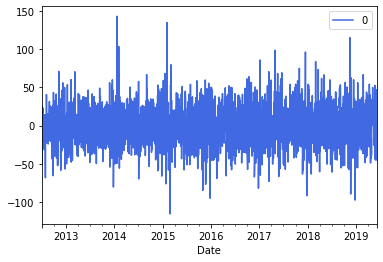

In [60]:
# Visualize residuals/error
residuals = pd.DataFrame(base_fit.resid)
residuals.plot(color='royalblue')
plt.show();

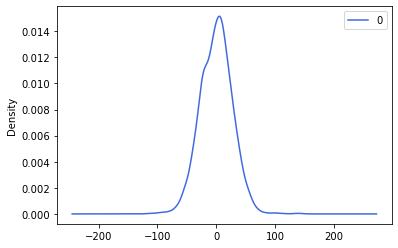

In [61]:
# Check for linearity
residuals = pd.DataFrame(base_fit.resid)
residuals.plot(kind='kde', color='royalblue')
plt.show()


Based on the first graph above, we see residuals centered and concentrated at 0, though with more variance than is ideal. With a mean at approximately 0, the second graph shows that our model is mostly linear.

**Test Predictions**

We know that this ARIMA model yielded our best test predictions from its RMSE and AIC score, but let's visualize our predictions compared to the true data.

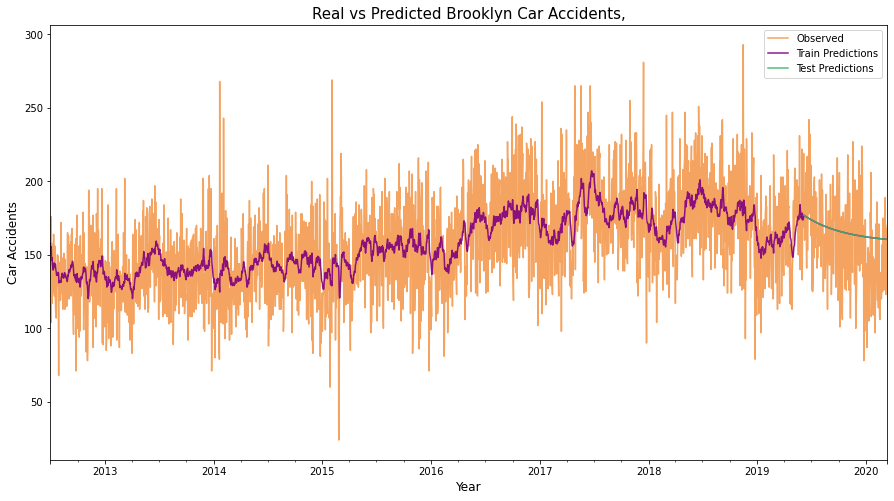

In [70]:
# Plot real vs predicted values
fix,ax = plt.subplots(figsize=(15, 8))

# Plot observed values
ax = df_bkln['Accidents_Bkln'].plot(label='Observed', color='sandybrown')

# Plot predicted train values
base_pred_train = base_fit.predict(start='2012-07-01', end='2020-03-13', dynamic=False)
base_pred_train.plot(ax=ax, label='Train Predictions', alpha=0.9, color='purple')

# Plot predicted values
base_pred.plot(ax=ax, label='Test Predictions', alpha=0.9, color='mediumseagreen')

# Set axes labels and title
ax.set_xlabel('Year', size=12)
ax.set_ylabel('Car Accidents',size=12)
ax.set_title('Real vs Predicted Brooklyn Car Accidents,', size=15)

plt.legend()
plt.show()

# Forecasting

Now that we see how our data performed on our train and test data, it is time to apply it to the future.

## July 1, 2021 through the end of 2021

As discussed in the EDA notebook, we will use our current model to predict accident numbers starting on July 1, 2021, assuming a 25% decrease from our model predictions.

In [71]:
# Generate predictions for specified dates
base_pred_2021 = base_fit.predict(start='2021-07-01', end='2021-12-31', dynamic=False)


ValueError: Length of passed values is 940, index implies 184.